In [ ]:
!pip install -U transformers
!pip install -U torch
!pip install gdown
!pip install sklearn
!pip install keras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

import torch
import gdown
import pickle
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertModel
from transformers import GPT2Tokenizer
from transformers import GPT2Model
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
# Clear GPU cache
torch.cuda.empty_cache()

# Check GPU memory usage
!nvidia-smi

Mon Apr 17 21:12:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")

GPU available: Tesla T4


# Data Import and Exploration

In [ ]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1IG7APAMDUOBfToE_NDM9uKczkIUNC5__d9BsEK1DMIY/edit#gid=1880462315'
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(url_1, header=None)
df

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
# Change header of the table
df = df.rename(columns={0:"t", 1:"x"})
df.head()

,t,x
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
# Number data examples per class
print(df['t'].value_counts())

neutral     2879
positive    1363
negative     604
Name: t, dtype: int64


In [ ]:
# Let's take a particular sentence
sentences = df['x'].to_numpy()
print(sentences[1])

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .


In [ ]:
# Number of sentences and number of vocab words
vocab = set([w for s in sentences for w in s])
print(len(sentences)) 
print(len(vocab)) 

4846
93


In [ ]:
# Let's take a look at a few more sentences
for i in range(10):
  print(sentences[i])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .
With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .
FINANCING OF ASPOCOMP 'S GROWTH Aspocomp 

In [ ]:
# Average length of sentences and total number of words in the data set
cnt = 0
sentences_cnt = 0
for sentence in sentences:
  sentences_cnt += 1
  for word in sentence.split():
      cnt += 1

print('Average length of sentence is {}'.format(cnt/sentences_cnt))
print('Number of words in total is {}'.format(cnt))

Average length of sentence is 23.092447379281882
Number of words in total is 111906


In [ ]:
# Top 10 most common words and number of total unique words in the data set
from collections import Counter
import numpy as np
cnt = Counter()
for sentence in sentences:
    for word in sentence.split():
      cnt[word] += 1

print('Top 10 most common words are: {} '.format(cnt.most_common(10)))

print('Number of unique words is {}'.format(len(cnt.keys())))


Top 10 most common words are: [('.', 4779), ('the', 4709), (',', 4660), ('of', 3199), ('in', 2752), ('and', 2583), ('to', 2495), ('a', 1630), ('The', 1354), ('for', 1127)] 
Number of unique words is 12966


## Data Transformation

In [ ]:
# Seperate the text and labels
texts = df['x'].to_numpy()
labels =  df['t'].to_numpy()

In [ ]:
#Set all the labels to integers instead of strings

# Encode the labels as integers
label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)

# Check mapping of new labels
class_labels = label_encoder.classes_
integer_encodings = label_encoder.transform(class_labels)

print("Class to Integer mappings")
for original_label, integer_encoding in zip(class_labels, integer_encodings):
    print(f'{original_label} -> {integer_encoding}')

print('\n')

Class to Integer mappings
negative -> 0
neutral -> 1
positive -> 2




## Split the data into train, validation and test set


In [ ]:
# Create the train, validation and test set.

X_train, X_test, t_train, t_test = train_test_split(texts, labels, test_size=0.4, random_state=42)

X_valid, X_test, t_valid, t_test = train_test_split(X_test, t_test, test_size=0.5, random_state=42)

print(f'Size of training set: {len(X_train)}')
print(f'Size of validation set: {len(X_valid)}')
print(f'Size of test set: {len(X_test)}')

Size of training set: 2907
Size of validation set: 969
Size of test set: 970


In [ ]:
#Find the longest text
max_text = 0
for text in X_train:
    if len(text) > max_text:
        max_text = len(text)
max_text

315

# Data Augmentation 

In [ ]:
# This code retrieves the augmented training data that is stored on a pickle file on google drive

sharing_link = 'https://drive.google.com/file/d/1-G3DpXnlZMItro-AKsg3m8GB3t_vU9MF/view?usp=sharing'
destination = 'aug_data.pkl'

# Get the file ID from the sharing link
file_id = sharing_link.split('/d/')[1].split('/view')[0]

# Download the file using the file ID
url = f'https://drive.google.com/uc?export=download&id={file_id}'
response = requests.get(url, allow_redirects=True)

with open(destination, 'wb') as file:
    file.write(response.content)


In [ ]:
# Retrieve data from the pickle file
with open(destination, 'rb') as file:
    data = pickle.load(file)

In [ ]:
data[1] = np.asarray(data[1], dtype=np.int64)

In [ ]:
# Example of the data augmentation
print(f'Original Text: {X_train[0]}')
print(f'Augmented Text: {data[0][0]}')

Original Text: Exel Composites ' long-term growth prospects remain favourable , however .
Augmented Text: However, Exel Composites 's long-term growth outlook remains favourable .


In [ ]:
# Append the augmented data to the 
X_train = np.append(X_train, data[0])
t_train = np.append(t_train, data[1])

# Data Preprocessing

First preprocess the data by tokenizeing the input texts and converting labels to one-hot vectors

In [ ]:
X_train = list(X_train)
X_valid = list(X_valid)
X_test = list(X_test)

t_train = torch.tensor(t_train)
t_valid = torch.tensor(t_valid)
t_test = torch.tensor(t_test)

## Preprocessing the data for BERT

In [ ]:
def preprocess_data_for_bert(texts, labels):
    # Load the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize the text using the BERT tokenizer
    input_ids = []
    attention_masks = []

    tokens = tokenizer(
        texts,
        max_length=327,
        padding=True,
        pad_to_max_length=True,
        return_tensors="pt",
    )

    input_ids = tokens['input_ids']
    attention_masks = tokens['attention_mask']

    data = TensorDataset(input_ids, attention_masks, labels)

    return data

In [ ]:
BERT_train_data = preprocess_data_for_bert(X_train, t_train)
BERT_valid_data = preprocess_data_for_bert(X_valid, t_valid)
BERT_test_data = preprocess_data_for_bert(X_test, t_test)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2377: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")


## Preprocessing the data for GPT

In [ ]:
def preprocess_data_for_gpt(texts, labels):
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    tokens = tokenizer(
        texts,
        max_length=327,
        padding=True,
        pad_to_max_length=True,
        return_tensors="pt",
    )

    input_ids = tokens['input_ids']
    attention_masks = tokens['attention_mask']

    data = TensorDataset(input_ids, attention_masks, labels)

    return data

In [ ]:
GPT_train_data = preprocess_data_for_gpt(X_train, t_train)
GPT_valid_data = preprocess_data_for_gpt(X_valid, t_valid)
GPT_test_data = preprocess_data_for_gpt(X_test, t_test)

In [ ]:
GPT_train_data.tensors

(tensor([[ 3109,   417, 29936,  ..., 50256, 50256, 50256],
         [  464, 10397, 12173,  ..., 50256, 50256, 50256],
         [29161,  8236,  4476,  ..., 50256, 50256, 50256],
         ...,
         [48650,  2291,  7914,  ..., 50256, 50256, 50256],
         [  464,  7696,   318,  ..., 50256, 50256, 50256],
         [    7,  5984,    47,  ..., 50256, 50256, 50256]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([2, 1, 1,  ..., 1, 1, 2]))

## Extract BERT and GPT-2 features

In [ ]:
def extract_bert_features(data, batch_size=16):
    input_ids = data.tensors[0]
    attention_mask = data.tensors[1]
    labels = data.tensors[2]
    model = BertModel.from_pretrained("bert-base-uncased")
    model = model.to(device)

    n = len(input_ids)
    cls_token_representations = []
    device_labels = []

    with torch.no_grad():
        for i in range(0, n, batch_size):
            batch_input_ids = input_ids[i:i+batch_size].to(device)
            batch_attention_mask = attention_mask[i:i+batch_size].to(device)
            batch_labels = labels[i:i+batch_size].to(device)

            output = model(batch_input_ids, attention_mask=batch_attention_mask)
            last_hidden_state = output[0]
            batch_cls_token_representation = last_hidden_state[:, 0, :].detach().cpu()

            cls_token_representations.append(batch_cls_token_representation)
            device_labels.append(torch.tensor(batch_labels))

    cls_token_representations = torch.cat(cls_token_representations, dim=0)
    device_labels = torch.cat(device_labels, dim=0)

    data_features = TensorDataset(cls_token_representations, device_labels)

    return data_features

In [ ]:
def extract_gpt_features(data, batch_size=10):
    input_ids = data.tensors[0]
    attention_mask = data.tensors[1]
    labels = data.tensors[2]

    n = len(input_ids)

    cls_token_representations = []
    device_labels = []

    model = GPT2Model.from_pretrained('gpt2')
    model = model.to(device)

    for i in range(0, n, batch_size):
        batch_input_ids = input_ids[i:i+batch_size].to(device)
        batch_attention_mask = attention_mask[i:i+batch_size].to(device)
        batch_labels = labels[i:i+batch_size].to(device)

        output = model(batch_input_ids, attention_mask=batch_attention_mask)
        last_hidden_state = output[0]
        batch_cls_token_representation = last_hidden_state[:, 0, :].detach().cpu()

        cls_token_representations.append(batch_cls_token_representation)
        device_labels.append(torch.tensor(batch_labels))

    cls_token_representations = torch.cat(cls_token_representations, dim=0)
    device_labels = torch.cat(device_labels, dim=0)

    data_features = TensorDataset(cls_token_representations, device_labels)

    return data_features

In [ ]:
BERT_train_features = extract_bert_features(BERT_train_data)
BERT_valid_features = extract_bert_features(BERT_valid_data)
BERT_test_features = extract_bert_features(BERT_test_data)

GPT_train_features = extract_gpt_features(GPT_train_data)
GPT_valid_features = extract_gpt_features(GPT_valid_data)
GPT_valid_features = extract_gpt_features(GPT_valid_data)

In [ ]:
BERT_train_features.tensors

(tensor([[-0.6111, -0.0009, -0.0422,  ..., -0.4646,  0.3188,  0.1968],
         [-0.5908, -0.0559,  0.2850,  ..., -0.0844, -0.0699, -0.1434],
         [-0.1474,  0.4503,  0.5347,  ..., -0.4194,  0.2055,  0.2555],
         ...,
         [-0.2456, -0.1422, -0.2120,  ..., -0.5723, -0.0284,  0.0741],
         [-0.2326,  0.0570,  0.0810,  ..., -0.0040, -0.0438,  0.6260],
         [-0.2532,  0.1912,  0.2760,  ..., -0.2116, -0.0366,  0.4481]]),
 tensor([2, 1, 1,  ..., 1, 1, 2], device='cuda:0'))

In [ ]:
GPT_train_features.tensors

(tensor([[ 0.0103, -0.0252, -0.2453,  ..., -0.1999, -0.0780, -0.1516],
         [-0.0470, -0.0333, -0.1626,  ..., -0.1337, -0.0571, -0.1059],
         [ 0.0234, -0.2450, -0.4955,  ..., -0.1233,  0.0074, -0.0138],
         ...,
         [ 0.0333,  0.1435, -0.5179,  ..., -0.0172, -0.0151,  0.0447],
         [-0.0470, -0.0333, -0.1626,  ..., -0.1337, -0.0571, -0.1059],
         [-0.1740,  0.0532, -0.2968,  ..., -0.0538, -0.0978, -0.1262]]),
 tensor([2, 1, 1,  ..., 1, 1, 2], device='cuda:0'))

# Model Architecture

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        y = self.fc5(x)
        return y

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(768, 256, kernel_size=1, padding=1)
        self.conv2 = nn.Conv1d(256, 128, kernel_size=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear(128, 3)

    def forward(self, x):
        x = x.unsqueeze(2)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
class DropoutMLP(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DropoutMLP, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 3)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        y = self.fc5(x)
        return y

# Set Up Training and Accuracy Functions

In [ ]:
def get_accuracy(model, data):
    loader = DataLoader(data, batch_size=50)

    model.eval() 

    correct = 0
    total = 0
    for text, labels in loader:
        text = text.to(device)
        labels = labels.to(device)
        values, y = torch.max(model.forward(text), dim=1)
        correct += (y == labels).sum().item()
        total += labels.shape[0]

    return correct/total # TODO: return the model accuracy

In [ ]:
def train(model, train_data, valid_data, batch_size=32, weight_decay=0.0, learning_rate=0.001, num_epochs=7, plot=False):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    
    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    n = 0

    model = model.to(device)
    for epoch in range(num_epochs):
        loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        
        for text, labels in loader:
            text = text.to(device)
            labels = labels.to(device)
            if text.size()[0] < batch_size:
              continue
            
            model.train() # annotate model for training
             
            out = model(text)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_accs.append(get_accuracy(model, train_data)) # compute training accuracy 
            val_accs.append(get_accuracy(model, valid_data))  # compute validation accuracy
            n += 1
    
    if plot:   
      plt.title("Learning Curve")
      plt.plot(iters, losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Learning Curve")
      plt.plot(iters, train_accs, label="Train")
      plt.plot(iters, val_accs, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_accs[-1]))
      print("Final Validation Accuracy: {}".format(val_accs[-1]))
    
    return (train_accs[-1], val_accs[-1])

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

def train2(model, train_data, valid_data, batch_size=32, weight_decay=0.0, learning_rate=0.001, num_epochs=7, plot=False):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    
    scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    grad_clip_value = 1.0

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    n = 0

    model = model.to(device)
    for epoch in range(num_epochs):
        loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        
        for text, labels in loader:
            text = text.to(device)
            labels = labels.to(device)
            if text.size()[0] < batch_size:
              continue
            
            model.train() # annotate model for training
             
            out = model(text)
            loss = criterion(out, labels)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)

            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()

            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_accs.append(get_accuracy(model, train_data)) # compute training accuracy 
            val_accs.append(get_accuracy(model, valid_data))  # compute validation accuracy
            n += 1
    
    
    if plot:   
      plt.title("Learning Curve")
      plt.plot(iters, losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Learning Curve")
      plt.plot(iters, train_accs, label="Train")
      plt.plot(iters, val_accs, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_accs[-1]))
      print("Final Validation Accuracy: {}".format(val_accs[-1]))
    
    return (train_accs[-1], val_accs[-1])


# Hyper Parameter Tuning

## Hyper Parameter Tuning for Bert Tokens, Train1

In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      mlp = MLP()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train(mlp, BERT_train_features, BERT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7110423116615067Training accuracy: 0.8806329549363605
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7069143446852425Training accuracy: 0.869453044375645
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7523219814241486Training accuracy: 0.9112487100103199
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7719298245614035Training accuracy: 0.8785689714482284
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7512899896800825Training accuracy: 0.8790849673202614
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7750257997936016Train

In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      cnn = CNNClassifier()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train(cnn, BERT_train_features, BERT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7316821465428277Training accuracy: 0.9165806673546611
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7327141382868937Training accuracy: 0.8998968008255934
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7151702786377709Training accuracy: 0.8632610939112487
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7750257997936016Training accuracy: 0.8880288957688338
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7543859649122807Training accuracy: 0.8630890952872377
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7543859649122807Trai

In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      modified_mlp = DropoutMLP()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train(modified_mlp, BERT_train_features, BERT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7708978328173375Training accuracy: 0.8713450292397661
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7729618163054696Training accuracy: 0.8455452356381149
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6811145510835913Training accuracy: 0.6912624699002408
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.7048503611971104Training accuracy: 0.7545579635362917
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6697626418988648Training accuracy: 0.7031303749570004
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Trai

## Hyper Parameter Tuning for Bert Tokens Train2


In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      mlp = MLP()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train2(mlp, BERT_train_features, BERT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Trai

In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      cnn = CNNClassifier()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train2(cnn, BERT_train_features, BERT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5949432404540763
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6553147574819401Training accuracy: 0.6547987616099071
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6656346749226006Trai

In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      modified_mlp = DropoutMLP()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train2(modified_mlp, BERT_train_features, BERT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.27966976264189886Training accuracy: 0.28104575163398693
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5056759545923633Training accuracy: 0.49656002751977985
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075T

## Hyper Parameter Tuning for GPT Tokens For Best Train


In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      mlp = MLP()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train(mlp, GPT_train_features, GPT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6171310629514963Training accuracy: 0.6231510147918816
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6181630546955624Training accuracy: 0.6197110423116615
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.608875128998968Training accuracy: 0.6131750945992432
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Train

In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      cnn = CNNClassifier()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train(cnn, GPT_train_features, GPT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6109391124871001Training accuracy: 0.6255589955280357
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6047471620227038Training accuracy: 0.6252149982800138
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.6140350877192983Training accuracy: 0.6150670794633643
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Trai

In [ ]:
highest_train_acc = 0
highest_valid_acc = 0
best_params = None
for batch in [16,32,64]:
  for lam in [0, 0.005, 0.01]:
    for alpha in [0.0005, 0.001, 0.005]:
      modified_mlp = DropoutMLP()
      print("Current Lamda: {}, Current Alpha: {}, Current batch: {}".format(lam, alpha, batch))
      train_acc, valid_acc = train(modified_mlp, GPT_train_features, GPT_valid_features, batch_size=batch, weight_decay=lam, learning_rate=alpha, num_epochs=15)
      print("Validation accuracy: "+str(valid_acc)+"Training accuracy: " + str(train_acc))
      if valid_acc > highest_valid_acc: #We choose the hyperparameters based on the validation accuracy
        highest_train_acc = train_acc
        highest_valid_acc = valid_acc
        best_params = (lam, alpha, batch)


print("Best Lamda: {}, Best Alpha: {}, Best Batch: {}".format(best_params[0], best_params[1], best_params[2]))
print("Highest training accuracy: {}".format(highest_train_acc))
print("Highest validation accuracy: {}".format(highest_valid_acc))

Current Lamda: 0, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.0005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.001, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Training accuracy: 0.5951152390780874
Current Lamda: 0.005, Current Alpha: 0.005, Current batch: 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation accuracy: 0.5985552115583075Trai

# Training

### Training final model with the optimal hyperparameters


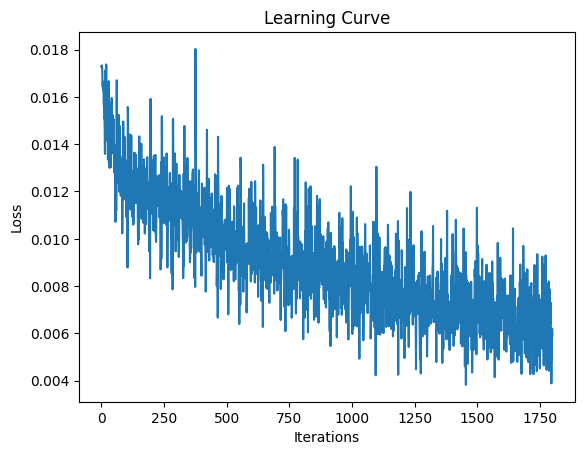

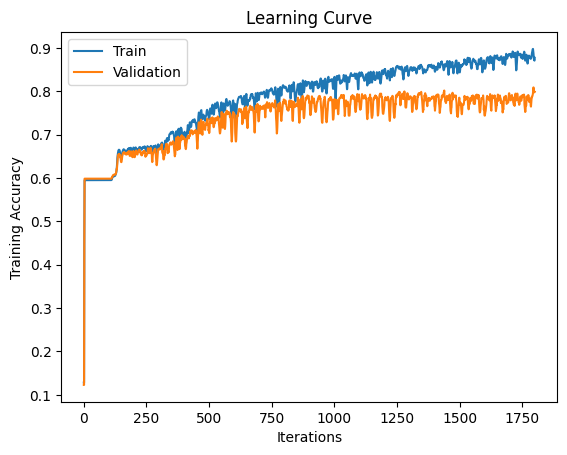

Final Training Accuracy: 0.8773649810801514
Final Validation Accuracy: 0.7987616099071208


In [ ]:
modified_mlp = DropoutMLP()
train_acc, valid_acc = train(modified_mlp, BERT_train_features, BERT_valid_features, batch_size=64, weight_decay=0, learning_rate=0.0005, num_epochs=20, plot=True)

# Final model performance on the test set


In [ ]:
get_accuracy(modified_mlp, BERT_test_features)

0.7855670103092783

We see that the model performed quite well with a test accuracy of almost 79%.

## Correctly classified example

In [ ]:
n = 0
for i in range(len(X_test)):
  text = BERT_test_features.tensors[0][i]
  label = BERT_test_features.tensors[1][i]
  text = text.unsqueeze(0).to(device)
  label = label.to(device)

  values, y = torch.max(modified_mlp.forward(text), dim=-1)

  if y == label:
      print(f'text: {X_test[i]}')
      print(f'predicted value: {y.item()}')
      print(f'label: {label}')
      print('\n')
      if n == 4:
        break
      
      n += 1


text: efficiency improvement measures 20 January 2010 - Finnish stationery and gift retailer Tiimari HEL : TII1V said today that it will continue to improve its operational efficiency , by focusing on its profitable core operations .
predicted value: 2
label: 2


text: CompaniesandMarkets.com provides a wide range of research reports , industry statistics and competitive intelligence on the industrial sector .
predicted value: 1
label: 1


text: The company has a wide selection of metal products and services .
predicted value: 1
label: 1


text: The devices also contains Finnair 's own application for compiling customer feed-back and ideas for product development .
predicted value: 1
label: 1


text: The board of directors also proposed that a dividend of EUR0 .20 per outstanding share be paid .
predicted value: 1
label: 1




The model correctly classified this text as positive (integer label 2)

## Incorrectly classified example

In [ ]:
n = 0
for i in range(len(X_test)):
  text = BERT_test_features.tensors[0][i]
  label = BERT_test_features.tensors[1][i]
  text = text.unsqueeze(0).to(device)
  label = label.to(device)

  values, y = torch.max(modified_mlp.forward(text), dim=-1)

  if y != label:
      print(f'text: {X_test[i]}')
      print(f'predicted value: {y.item()}')
      print(f'label: {label}')
      print('\n')
      if n == 4:
        break
      n += 1

text: The company also said that the deployment of the Danish 4G network continues and it expects to cover 75 % of the Danish population in 2011 .
predicted value: 2
label: 1


text: The maritime administration said the ships had ignored warnings about the icy conditions .
predicted value: 1
label: 0


text: It is also 7.7 pct above the 12-month volume weighted average price of the stock .
predicted value: 1
label: 2


text: Profit after taxes was EUR 0.1 mn , compared to EUR -0.4 mn the previous year .
predicted value: 0
label: 2


text: The newly-completed Allure of the Seas and its identical sister ship , Oasis of the Seas , which was completed last year are the world 's largest cruise ships .
predicted value: 2
label: 1




These are some of the examples of texts the model classified incorrectly. The model classified text in the first example as positive (integer label 2), when the correct label is neutral (integer label 1).

## Visualization of `True` vs `Predicted` Sentiments in the Test Set


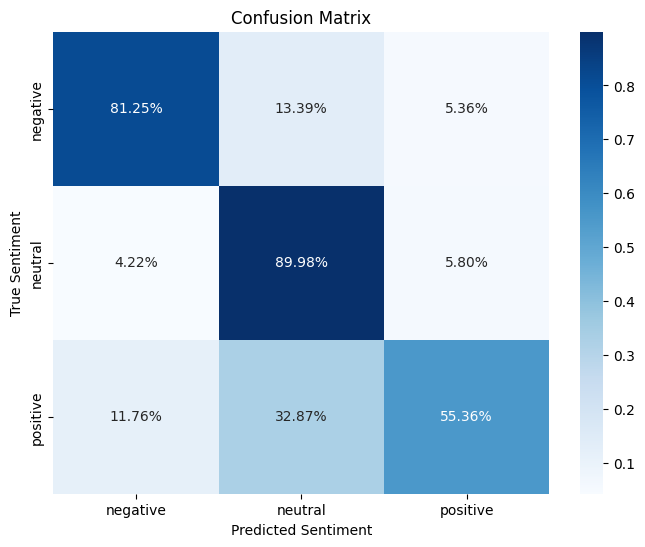

In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for text, labels in data_loader:
            text = text.to(device)
            labels = labels.to(device)

            outputs = model(text)
            _, predicted_labels = torch.max(outputs, 1)

            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)


test_loader = torch.utils.data.DataLoader(BERT_test_features, batch_size=64)


predicted_labels, true_labels = get_predictions(modified_mlp, test_loader)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Reprecent values of the confusion matrix as proportions relative to their class
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix')
plt.show()

